# Validating AirNow Data
The goal is to validate the airnow data against key landmarks.

Current landmarks:
- Palisades/Eaton fire
- 4th of July

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

BASE_DIR = '/home/mgraca/Workspace/hrrr-smoke-viz'
CACHE_DIR = f'{BASE_DIR}/pwwb-experiments/tensorflow/cached_data/two_years_sat_data'
AIRNOW_CACHE_PATH = f'{CACHE_DIR}/airnow_cache/airnow_processed.npz'
AOD_CACHE_PATH = f'{CACHE_DIR}/goes_cache/goes_processed.npz'
NO2_CACHE_PATH = f'{CACHE_DIR}/tempo_cache/tempo_l3_no2_20230802_20250802_hourly.npz'

sys.path.append(BASE_DIR)

dates_of_interest = {
    'Independence Day 2024' : pd.to_datetime("2024-07-04").tz_localize('America/Los_Angeles'),
    'Independence Day 2025' : pd.to_datetime("2025-07-04").tz_localize('America/Los_Angeles'),
    'Palisades/Eaton Fire' : pd.to_datetime("2025-01-10").tz_localize('America/Los_Angeles'),
}
dates_of_interest['Independence Day 2025']

Timestamp('2025-07-04 00:00:00-0700', tz='America/Los_Angeles')

In [2]:
START_DATE = "2023-08-02-00"
END_DATE = "2025-08-02-00"

dates = pd.date_range(START_DATE, END_DATE, inclusive='left', freq='h', tz='utc').tz_convert('America/Los_Angeles')
dates

DatetimeIndex(['2023-08-01 17:00:00-07:00', '2023-08-01 18:00:00-07:00',
               '2023-08-01 19:00:00-07:00', '2023-08-01 20:00:00-07:00',
               '2023-08-01 21:00:00-07:00', '2023-08-01 22:00:00-07:00',
               '2023-08-01 23:00:00-07:00', '2023-08-02 00:00:00-07:00',
               '2023-08-02 01:00:00-07:00', '2023-08-02 02:00:00-07:00',
               ...
               '2025-08-01 07:00:00-07:00', '2025-08-01 08:00:00-07:00',
               '2025-08-01 09:00:00-07:00', '2025-08-01 10:00:00-07:00',
               '2025-08-01 11:00:00-07:00', '2025-08-01 12:00:00-07:00',
               '2025-08-01 13:00:00-07:00', '2025-08-01 14:00:00-07:00',
               '2025-08-01 15:00:00-07:00', '2025-08-01 16:00:00-07:00'],
              dtype='datetime64[ns, America/Los_Angeles]', length=17544, freq='h')

In [3]:
sensor_locations = {
    'Simi Valley - Cochran Street': (8, 1),
    'Reseda': (12, 4),
    'Santa Clarita': (4, 5),
    'North Holywood': (12, 8),
    'Los Angeles - N. Main Street': (17, 11),
    'Compton': (23, 12),
    'Long Beach Signal Hill': (28, 13),
    'Anaheim': (26, 18),
    'Glendora - Laurel': (14, 20),
    'Mira Loma - Van Buren': (20, 28),
    'Riverside - Rubidoux': (20, 30),
    'Lake Elsinore - W. Flint Street': (32, 32),
    'Crestline - Lake Gregory': (10, 33),
    'Temecula (Lake Skinner)': (36, 38),
    'Fontana - Arrow Highway': (15, 28)
}

sensor_x_vals, sensor_y_vals = [], []
for x, y in sensor_locations.values():
    sensor_x_vals.append(x)
    sensor_y_vals.append(y)

In [4]:
pm25 = np.load(AIRNOW_CACHE_PATH)['data'][:, sensor_x_vals, sensor_y_vals]
aod = np.load(AOD_CACHE_PATH)['data']
no2 = np.load(NO2_CACHE_PATH)['data']
print(pm25.shape, aod.shape, no2.shape)

avg_pm25 = np.mean(pm25, axis=(1))
avg_aod = np.mean(aod, axis=(1, 2))
avg_no2 = np.mean(no2, axis=(1, 2))

print(avg_pm25.shape, avg_aod.shape, avg_no2.shape)

(17544, 15) (17544, 40, 40) (17544, 40, 40)
(17544,) (17544,) (17544,)


In [5]:
processed_df = pd.DataFrame({
    'date (pst)' : dates,
    'pm25' : avg_pm25,
    'aod'  : avg_aod,
    'no2'  : avg_no2,
})
processed_df

,date (pst),pm25,aod,no2
0,2023-08-01 17:00:00-07:00,11.726666,0.147870,0.001000
1,2023-08-01 18:00:00-07:00,11.820001,0.114028,0.001000
2,2023-08-01 19:00:00-07:00,11.860001,0.078072,0.001000
3,2023-08-01 20:00:00-07:00,11.380001,0.078072,0.001000
4,2023-08-01 21:00:00-07:00,11.906668,0.078072,0.001000
...,...,...,...,...
17539,2025-08-01 12:00:00-07:00,13.017777,0.060451,0.538268
17540,2025-08-01 13:00:00-07:00,12.708889,0.060451,0.538268
17541,2025-08-01 14:00:00-07:00,11.771110,0.060451,0.538268
17542,2025-08-01 15:00:00-07:00,11.300000,0.060451,0.538268


In [6]:
def plot(event, day_range, dates_of_interest=dates_of_interest, df=processed_df):
    lo = dates_of_interest[event] - pd.Timedelta(days=day_range)
    hi = dates_of_interest[event] + pd.Timedelta(days=day_range)
    date_range = (df['date (pst)'] > lo) & (df['date (pst)'] < hi)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    plt.suptitle(event)
    df[date_range].plot(ax=axes[0], x='date (pst)', y='pm25', color='blue')
    df[date_range].plot(ax=axes[1], x='date (pst)', y='aod', color='red')
    df[date_range].plot(ax=axes[2], x='date (pst)', y='no2', color='green')
    plt.tight_layout()
    plt.show()

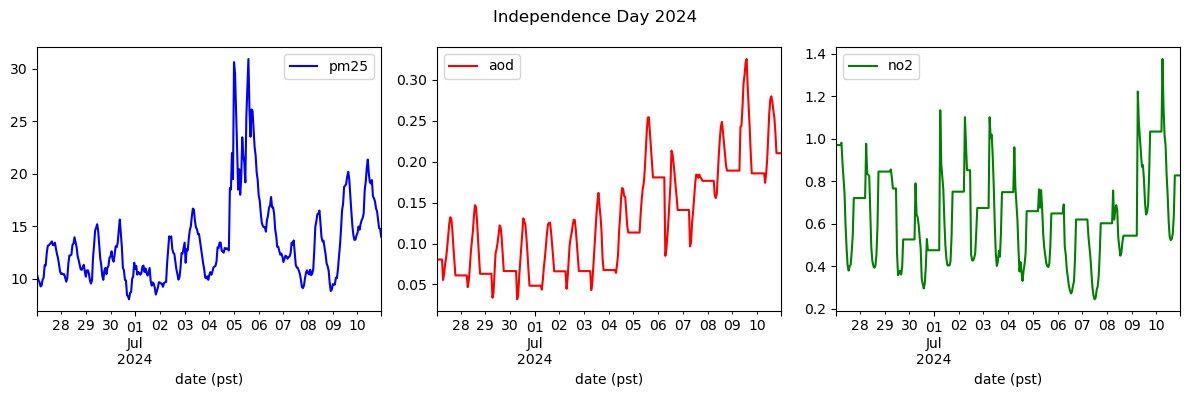

In [7]:
plot(event='Independence Day 2024', day_range=7)

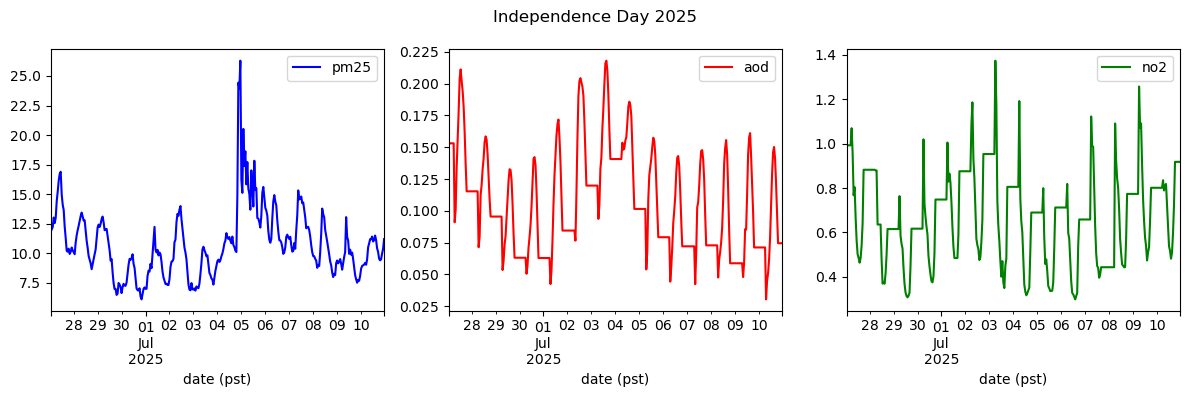

In [8]:
plot(event='Independence Day 2025', day_range=7)

https://www.sciencedirect.com/science/article/pii/S1352231015301369

- We report early-July hourly particulate (PM2.5) levels at 315 US monitoring sites.
- PM2.5 concentrations are elevated on July 4 evening and July 5 morning.
- Increases are largest at 9–10 pm on July 4 and diminish by noon on July 5.
- On national average, holiday 24-hr PM2.5 levels are elevated by 5 μg/m3 (42%).
- A site adjacent to fireworks shows 48 μg/m3 (370%) increases in 24-hr PM2.5.

# Loading directly from JSON

In [9]:
import json

AIRNOW_JSON_PATH = f'{CACHE_DIR}/airnow_cache/airnow.json'
data = pd.read_json(AIRNOW_JSON_PATH)
data

,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode
0,34.276320,-118.683690,2023-08-02T00:00,PM2.5,UG/M3,9.8,8.0,52,2,Simi Valley - Cochran Street,Ventura County APCD,061112002,840061112002
1,34.199200,-118.533100,2023-08-02T00:00,PM2.5,UG/M3,9.9,10.2,52,2,Reseda,South Coast AQMD,060371201,840060371201
2,34.383300,-118.528300,2023-08-02T00:00,PM2.5,UG/M3,9.6,9.9,52,2,Santa Clarita,South Coast AQMD,060376012,840060376012
3,34.181977,-118.363036,2023-08-02T00:00,PM2.5,UG/M3,10.5,10.8,54,2,North Holywood,South Coast AQMD,840060374010,840060374010
4,34.066429,-118.226755,2023-08-02T00:00,PM2.5,UG/M3,17.8,16.4,67,2,Los Angeles - N. Main Street,South Coast AQMD,060371103,840060371103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256565,34.100132,-117.491982,2025-08-01T23:00,PM2.5,UG/M3,13.3,10.3,59,2,Fontana - Arrow Highway,South Coast AQMD,060712002,840060712002
256566,33.999449,-117.415831,2025-08-01T23:00,PM2.5,UG/M3,12.8,11.2,58,2,Riverside - Rubidoux,South Coast AQMD,060658001,840060658001
256567,33.676535,-117.331027,2025-08-01T23:00,PM2.5,UG/M3,9.6,9.5,52,2,Lake Elsinore - W. Flint Street,South Coast AQMD,060659001,840060659001
256568,34.243132,-117.272275,2025-08-01T23:00,PM2.5,UG/M3,7.4,6.9,41,1,Crestline - Lake Gregory,South Coast AQMD,060710005,840060710005


## Analysis of Raw Data

### Removing sensors that have < 25% uptime

In [10]:
data.groupby('UTC').size().sort_values()

UTC
2024-05-10T20:00    10
2024-05-10T21:00    11
2025-01-22T19:00    11
2024-06-26T22:00    11
2025-01-22T20:00    11
                    ..
2025-05-22T15:00    17
2025-05-24T03:00    17
2025-05-24T02:00    17
2025-05-24T01:00    17
2025-05-22T19:00    17
Length: 17544, dtype: int64

In [11]:
data[data['UTC'] == '2024-05-10T20:00']

,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode
98318,34.276320,-118.683690,2024-05-10T20:00,PM2.5,UG/M3,18.5,21.0,69,2,Simi Valley - Cochran Street,Ventura County APCD,061112002,840061112002
98319,34.199200,-118.533100,2024-05-10T20:00,PM2.5,UG/M3,14.2,12.1,61,2,Reseda,South Coast AQMD,060371201,840060371201
98320,34.383300,-118.528300,2024-05-10T20:00,PM2.5,UG/M3,14.3,17.4,61,2,Santa Clarita,South Coast AQMD,060376012,840060376012
98321,34.066429,-118.226755,2024-05-10T20:00,PM2.5,UG/M3,19.2,19.0,70,2,Los Angeles - N. Main Street,South Coast AQMD,060371103,840060371103
98322,33.793713,-118.171019,2024-05-10T20:00,PM2.5,UG/M3,17.3,14.7,66,2,Long Beach Signal Hill,South Coast AQMD,840060374009,840060374009
98323,33.996387,-117.492500,2024-05-10T20:00,PM2.5,UG/M3,17.5,20.4,67,2,Mira Loma - Van Buren,South Coast AQMD,060658005,840060658005
98324,34.100132,-117.491982,2024-05-10T20:00,PM2.5,UG/M3,19.8,19.5,71,2,Fontana - Arrow Highway,South Coast AQMD,060712002,840060712002
98325,33.676535,-117.331027,2024-05-10T20:00,PM2.5,UG/M3,8.2,5.8,46,1,Lake Elsinore - W. Flint Street,South Coast AQMD,060659001,840060659001
98326,34.243132,-117.272275,2024-05-10T20:00,PM2.5,UG/M3,5.0,9.5,28,1,Crestline - Lake Gregory,South Coast AQMD,060710005,840060710005
98327,33.583099,-117.072197,2024-05-10T20:00,PM2.5,UG/M3,10.1,9.5,53,2,Temecula (Lake Skinner),South Coast AQMD,060650016,840060650016


In [12]:
data[data['UTC'] == '2025-05-21T21:00']

,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode
230007,34.276320,-118.683690,2025-05-21T21:00,PM2.5,UG/M3,8.9,12.0,49,1,Simi Valley - Cochran Street,Ventura County APCD,061112002,840061112002
230008,34.199200,-118.533100,2025-05-21T21:00,PM2.5,UG/M3,11.1,8.9,55,2,Reseda,South Coast AQMD,060371201,840060371201
230009,34.383300,-118.528300,2025-05-21T21:00,PM2.5,UG/M3,7.5,6.1,42,1,Santa Clarita,South Coast AQMD,060376012,840060376012
230010,34.181977,-118.363036,2025-05-21T21:00,PM2.5,UG/M3,12.4,11.0,57,2,North Holywood,South Coast AQMD,840060374010,840060374010
230011,34.066429,-118.226755,2025-05-21T21:00,PM2.5,UG/M3,17.8,14.5,67,2,Los Angeles - N. Main Street,South Coast AQMD,060371103,840060371103
230012,33.901400,-118.205000,2025-05-21T21:00,PM2.5,UG/M3,14.7,13.5,61,2,Compton,South Coast AQMD,060371302,840060371302
230013,33.793713,-118.171019,2025-05-21T21:00,PM2.5,UG/M3,9.8,8.3,52,2,Long Beach Signal Hill,South Coast AQMD,840060374009,840060374009
230014,33.830586,-117.938509,2025-05-21T21:00,PM2.5,UG/M3,15.5,12.0,63,2,Anaheim,South Coast AQMD,060590007,840060590007
230015,34.143900,-117.850800,2025-05-21T21:00,PM2.5,UG/M3,11.9,10.8,56,2,Glendora - Laurel,South Coast AQMD,060370016,840060370016
230016,33.996387,-117.492500,2025-05-21T21:00,PM2.5,UG/M3,11.4,11.8,55,2,Mira Loma - Van Buren,South Coast AQMD,060658005,840060658005


In [13]:
# data['FullAQSCode'].value_counts() / 17544 * 100
(data.groupby(['FullAQSCode', 'SiteName']).size() / 17544 * 100).sort_values(ascending=False)

FullAQSCode   SiteName                       
061112002     Simi Valley - Cochran Street       98.774510
840060374010  North Holywood                     98.392613
060658001     Riverside - Rubidoux               98.284314
060650016     Temecula (Lake Skinner)            97.982216
060376012     Santa Clarita                      97.982216
060658005     Mira Loma - Van Buren              97.777018
060659001     Lake Elsinore - W. Flint Street    97.566119
060710005     Crestline - Lake Gregory           97.378021
060371103     Los Angeles - N. Main Street       97.372321
060590007     Anaheim                            96.591427
060371201     Reseda                             96.488828
840060374009  Long Beach Signal Hill             95.970132
060371302     Compton                            95.953032
060370016     Glendora - Laurel                  95.046740
060712002     Fontana - Arrow Highway            94.465344
840MMCA82048  N/A                                 5.945052
840MMCA820

We should definitely exclude the sensors that report >25% downtime to dynamically get rid of the problematic sensors insetad of hardcoding it.

In [14]:
filtered_by_uptime = data.groupby('FullAQSCode').filter(lambda x : len(x) / 17544 * 100 > 25).copy()
(filtered_by_uptime.groupby(['FullAQSCode', 'SiteName']).size() / 17544 * 100).sort_values(ascending=False)

FullAQSCode   SiteName                       
061112002     Simi Valley - Cochran Street       98.774510
840060374010  North Holywood                     98.392613
060658001     Riverside - Rubidoux               98.284314
060650016     Temecula (Lake Skinner)            97.982216
060376012     Santa Clarita                      97.982216
060658005     Mira Loma - Van Buren              97.777018
060659001     Lake Elsinore - W. Flint Street    97.566119
060710005     Crestline - Lake Gregory           97.378021
060371103     Los Angeles - N. Main Street       97.372321
060590007     Anaheim                            96.591427
060371201     Reseda                             96.488828
840060374009  Long Beach Signal Hill             95.970132
060371302     Compton                            95.953032
060370016     Glendora - Laurel                  95.046740
060712002     Fontana - Arrow Highway            94.465344
dtype: float64

In [15]:
filtered_by_uptime.groupby('UTC').size().sort_values()

UTC
2024-05-10T20:00    10
2024-05-10T18:00    11
2025-01-22T19:00    11
2024-05-10T19:00    11
2025-01-22T20:00    11
                    ..
2023-08-03T19:00    15
2023-08-02T03:00    15
2023-08-02T02:00    15
2023-08-02T01:00    15
2023-08-02T00:00    15
Length: 17544, dtype: int64

In [16]:
data = filtered_by_uptime

In [17]:
[group for name, group in data.groupby('UTC')][0]

,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode
0,34.276320,-118.683690,2023-08-02T00:00,PM2.5,UG/M3,9.8,8.0,52,2,Simi Valley - Cochran Street,Ventura County APCD,061112002,840061112002
1,34.199200,-118.533100,2023-08-02T00:00,PM2.5,UG/M3,9.9,10.2,52,2,Reseda,South Coast AQMD,060371201,840060371201
2,34.383300,-118.528300,2023-08-02T00:00,PM2.5,UG/M3,9.6,9.9,52,2,Santa Clarita,South Coast AQMD,060376012,840060376012
3,34.181977,-118.363036,2023-08-02T00:00,PM2.5,UG/M3,10.5,10.8,54,2,North Holywood,South Coast AQMD,840060374010,840060374010
4,34.066429,-118.226755,2023-08-02T00:00,PM2.5,UG/M3,17.8,16.4,67,2,Los Angeles - N. Main Street,South Coast AQMD,060371103,840060371103
5,33.901400,-118.205000,2023-08-02T00:00,PM2.5,UG/M3,14.4,12.5,61,2,Compton,South Coast AQMD,060371302,840060371302
6,33.793713,-118.171019,2023-08-02T00:00,PM2.5,UG/M3,14.9,17.4,62,2,Long Beach Signal Hill,South Coast AQMD,840060374009,840060374009
7,33.830586,-117.938509,2023-08-02T00:00,PM2.5,UG/M3,7.5,6.1,42,1,Anaheim,South Coast AQMD,060590007,840060590007
8,34.143900,-117.850800,2023-08-02T00:00,PM2.5,UG/M3,18.4,22.6,68,2,Glendora - Laurel,South Coast AQMD,060370016,840060370016
9,33.996387,-117.492500,2023-08-02T00:00,PM2.5,UG/M3,9.7,9.2,52,2,Mira Loma - Van Buren,South Coast AQMD,060658005,840060658005


### Replacing negative values with 0
Note that some sensors also just simply don't report any values; see above.

In [18]:
len(data[data['Value'] < 0]['Value']) / len(data) * 100

0.22039969465051185

In [19]:
len(data[data['Value'] == 0]['Value']) / len(data) * 100

1.7753332419894692

In [20]:
len(data[data['Value'] < 0.5]['Value']) / len(data) * 100

2.6921646538393786

In [21]:
len(data[data['Value'] < 1]['Value']) / len(data) * 100

3.8137368122296387

0.22% are invalid, and 1.7% of observations report exactly 0 PM2.5. Is this valid? Should we allow 0.1, 0.2, etc.?

We currently move negatives to 0, then impute 0s with nearest neighbors. Can we say that 0.1 is more "valid" than 0? Should we consider 0 a valid observation?

In [22]:
# minimal cleaning: remove negative values
data.loc[data['Value'] < 0, 'Value'] = 0
data.loc[data['RawConcentration'] < 0, 'RawConcentration'] = 0

In [23]:
data.to_json(f'{CACHE_DIR}/airnow_cache/airnow_cleaned.json', orient='records', indent=4)

In [24]:
peek = pd.read_json(f'{CACHE_DIR}/airnow_cache/airnow_cleaned.json')
peek

,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode
0,34.276320,-118.683690,2023-08-02T00:00,PM2.5,UG/M3,9.8,8.0,52,2,Simi Valley - Cochran Street,Ventura County APCD,61112002,840061112002
1,34.199200,-118.533100,2023-08-02T00:00,PM2.5,UG/M3,9.9,10.2,52,2,Reseda,South Coast AQMD,60371201,840060371201
2,34.383300,-118.528300,2023-08-02T00:00,PM2.5,UG/M3,9.6,9.9,52,2,Santa Clarita,South Coast AQMD,60376012,840060376012
3,34.181977,-118.363036,2023-08-02T00:00,PM2.5,UG/M3,10.5,10.8,54,2,North Holywood,South Coast AQMD,840060374010,840060374010
4,34.066429,-118.226755,2023-08-02T00:00,PM2.5,UG/M3,17.8,16.4,67,2,Los Angeles - N. Main Street,South Coast AQMD,60371103,840060371103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255440,34.100132,-117.491982,2025-08-01T23:00,PM2.5,UG/M3,13.3,10.3,59,2,Fontana - Arrow Highway,South Coast AQMD,60712002,840060712002
255441,33.999449,-117.415831,2025-08-01T23:00,PM2.5,UG/M3,12.8,11.2,58,2,Riverside - Rubidoux,South Coast AQMD,60658001,840060658001
255442,33.676535,-117.331027,2025-08-01T23:00,PM2.5,UG/M3,9.6,9.5,52,2,Lake Elsinore - W. Flint Street,South Coast AQMD,60659001,840060659001
255443,34.243132,-117.272275,2025-08-01T23:00,PM2.5,UG/M3,7.4,6.9,41,1,Crestline - Lake Gregory,South Coast AQMD,60710005,840060710005


### Processed data options
- Let IDW handle imputation (anything that's 0 -- that's any sensor that was either absent or reported negative pm2.5)

In [25]:
from libs.airnowdata import AirNowData
AND = AirNowData(
    save_dir=f'{CACHE_DIR}/airnow_cache/airnow_cleaned.json',
    processed_cache_dir=f'{CACHE_DIR}/airnow_cache/airnow_processing_experiments.npz',
    idw_power=2,
    elevation_path=None,
    force_reprocess=False,
    use_interpolation=True, # determines if interpolation should be run
    impute_dead=False,
    impute_outlier=True,
    use_variable_blur=False,# determines if variable blur is used after interpolation
    verbose=0,              # 0=allow all, 1=progress bar only, 2=silence all except warning
)

print(AND.data.shape)
print(AND.air_sens_loc)

Loading processed AirNow data from cache: /home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/cached_data/two_years_sat_data/airnow_cache/airnow_processing_experiments.npz
✓ Successfully loaded processed data from cache
  - Data shape: (17544, 40, 40)
  - Found 15 sensor locations
(17544, 40, 40)
{'Simi Valley - Cochran Street': (8, 1), 'Reseda': (12, 4), 'Santa Clarita': (4, 5), 'North Holywood': (12, 8), 'Los Angeles - N. Main Street': (17, 11), 'Compton': (23, 12), 'Long Beach Signal Hill': (28, 13), 'Anaheim': (26, 18), 'Glendora - Laurel': (14, 20), 'Mira Loma - Van Buren': (20, 28), 'Fontana - Arrow Highway': (15, 28), 'Riverside - Rubidoux': (20, 30), 'Lake Elsinore - W. Flint Street': (32, 32), 'Crestline - Lake Gregory': (10, 33), 'Temecula (Lake Skinner)': (36, 38)}


In [26]:
# no dead sensor impute. yes outlier impute. yes interpolation
avg_pm25_1 = np.mean(AND.data[:, sensor_x_vals, sensor_y_vals], axis=(1))
processed_2_df = pd.DataFrame({
    'date (pst)' : dates,
    'pm25' : avg_pm25_1
})
processed_2_df

,date (pst),pm25
0,2023-08-01 17:00:00-07:00,11.726666
1,2023-08-01 18:00:00-07:00,11.820001
2,2023-08-01 19:00:00-07:00,11.860001
3,2023-08-01 20:00:00-07:00,11.380001
4,2023-08-01 21:00:00-07:00,11.906668
...,...,...
17539,2025-08-01 12:00:00-07:00,13.101399
17540,2025-08-01 13:00:00-07:00,12.719965
17541,2025-08-01 14:00:00-07:00,11.798573
17542,2025-08-01 15:00:00-07:00,11.310362


### Final data

In [27]:
mean_raw_con = data.groupby('UTC')['RawConcentration'].mean()
mean_nowcast = data.groupby('UTC')['Value'].mean()
mean_processed = processed_df['pm25']
stats_data = {
    'processed' : [mean_processed.mean(), mean_processed.median(), mean_processed.std(), mean_processed.min(), mean_processed.max()],
    'raw_con' : [mean_raw_con.mean(), mean_raw_con.median(), mean_raw_con.std(), mean_raw_con.min(), mean_raw_con.max()],
    'nowcast' : [mean_nowcast.mean(), mean_nowcast.median(), mean_nowcast.std(), mean_nowcast.min(), mean_nowcast.max()],
}
stats_df = pd.DataFrame(
    stats_data,
    index=['mean', 'median', 'std', 'min', 'max']
)
stats_df

,processed,raw_con,nowcast
mean,9.961563,10.216516,10.174698
median,9.646667,9.606667,9.607143
std,4.240114,5.641162,5.494759
min,1.428889,0.700000,0.842857
max,30.930918,97.546667,84.150000


In [28]:
nowcast_df = pd.DataFrame({
    'date (pst)' : dates,
    'pm25' : mean_nowcast,
    'aod'  : avg_aod,
    'no2'  : avg_no2,
}).reset_index()
nowcast_df

,UTC,date (pst),pm25,aod,no2
0,2023-08-02T00:00,2023-08-01 17:00:00-07:00,11.726667,0.147870,0.001000
1,2023-08-02T01:00,2023-08-01 18:00:00-07:00,11.820000,0.114028,0.001000
2,2023-08-02T02:00,2023-08-01 19:00:00-07:00,11.860000,0.078072,0.001000
3,2023-08-02T03:00,2023-08-01 20:00:00-07:00,11.380000,0.078072,0.001000
4,2023-08-02T04:00,2023-08-01 21:00:00-07:00,11.906667,0.078072,0.001000
...,...,...,...,...,...
17539,2025-08-01T19:00,2025-08-01 12:00:00-07:00,13.078571,0.060451,0.538268
17540,2025-08-01T20:00,2025-08-01 13:00:00-07:00,12.692857,0.060451,0.538268
17541,2025-08-01T21:00,2025-08-01 14:00:00-07:00,11.792857,0.060451,0.538268
17542,2025-08-01T22:00,2025-08-01 15:00:00-07:00,11.350000,0.060451,0.538268


In [29]:
rawcon_df = pd.DataFrame({
    'date (pst)' : dates,
    'pm25' : mean_raw_con,
    'aod'  : avg_aod,
    'no2'  : avg_no2,
}).reset_index()
rawcon_df

,UTC,date (pst),pm25,aod,no2
0,2023-08-02T00:00,2023-08-01 17:00:00-07:00,11.560000,0.147870,0.001000
1,2023-08-02T01:00,2023-08-01 18:00:00-07:00,11.980000,0.114028,0.001000
2,2023-08-02T02:00,2023-08-01 19:00:00-07:00,11.920000,0.078072,0.001000
3,2023-08-02T03:00,2023-08-01 20:00:00-07:00,10.960000,0.078072,0.001000
4,2023-08-02T04:00,2023-08-01 21:00:00-07:00,12.400000,0.078072,0.001000
...,...,...,...,...,...
17539,2025-08-01T19:00,2025-08-01 12:00:00-07:00,12.635714,0.060451,0.538268
17540,2025-08-01T20:00,2025-08-01 13:00:00-07:00,12.321429,0.060451,0.538268
17541,2025-08-01T21:00,2025-08-01 14:00:00-07:00,10.957143,0.060451,0.538268
17542,2025-08-01T22:00,2025-08-01 15:00:00-07:00,10.878571,0.060451,0.538268


## Independence Day Case Study

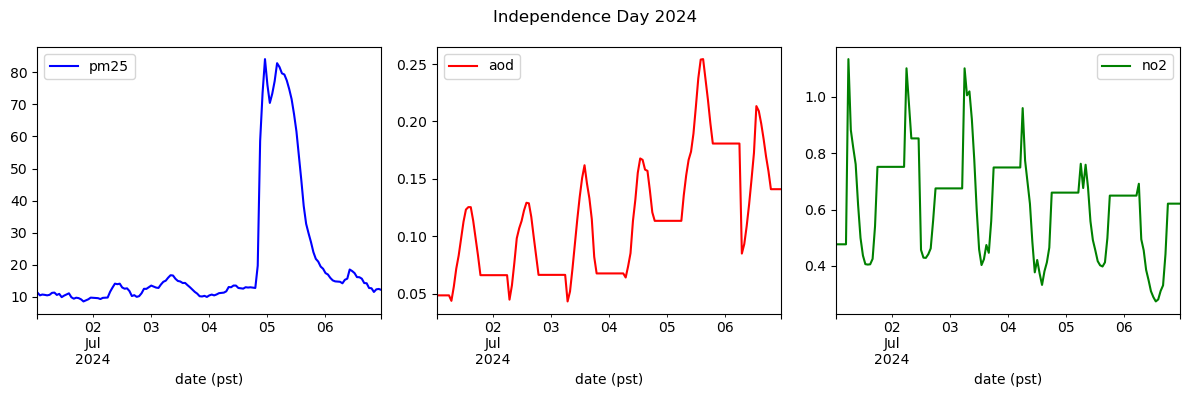

In [30]:
plot(event='Independence Day 2024', day_range=3, df=nowcast_df)

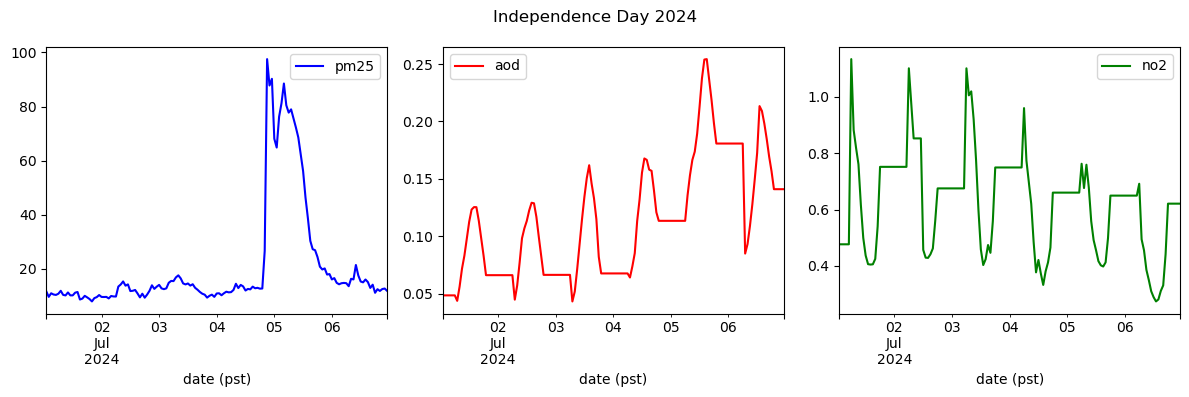

In [31]:
plot(event='Independence Day 2024', day_range=3, df=rawcon_df)

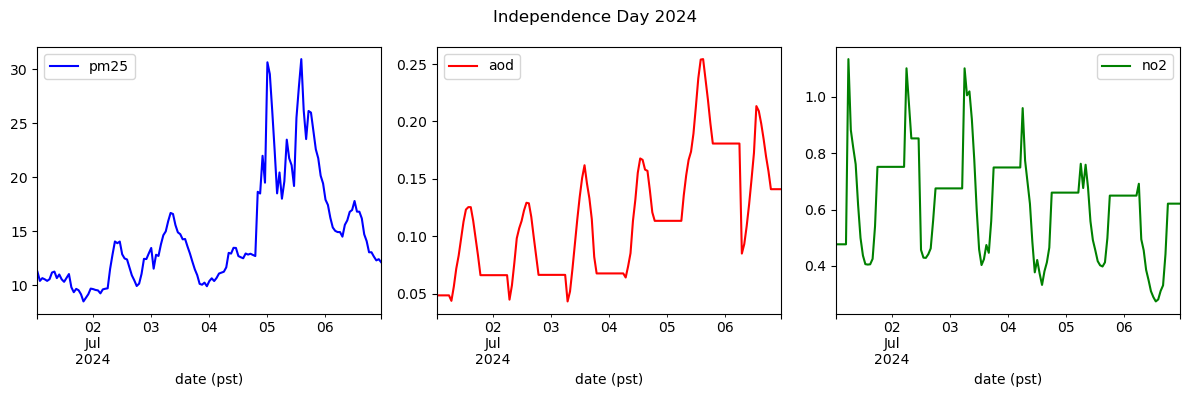

In [32]:
plot(event='Independence Day 2024', day_range=3, df=processed_df)

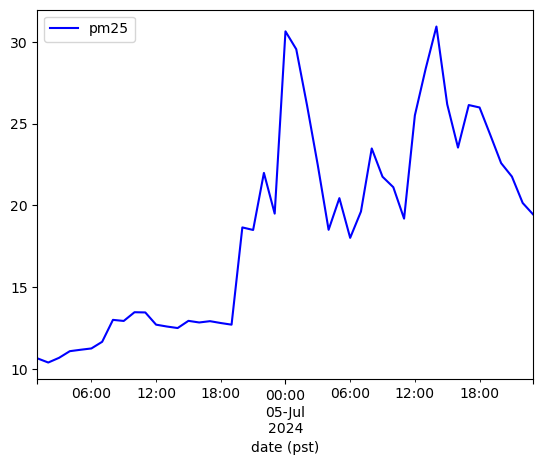

In [33]:
def plot_fwd(event, days_fwd, dates_of_interest=dates_of_interest, df=processed_df):
    lo = dates_of_interest[event]
    hi = dates_of_interest[event] + pd.Timedelta(days=days_fwd)
    date_range = (df['date (pst)'] > lo) & (df['date (pst)'] < hi)
    df[date_range].plot(x='date (pst)', y='pm25', color='blue')

plot_fwd('Independence Day 2024', 2)

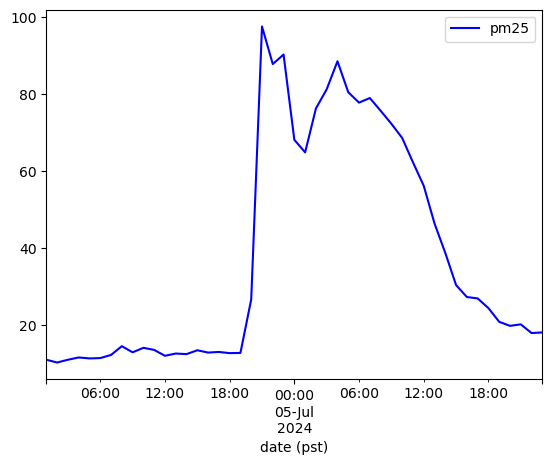

In [34]:
plot_fwd('Independence Day 2024', 2, df=rawcon_df)

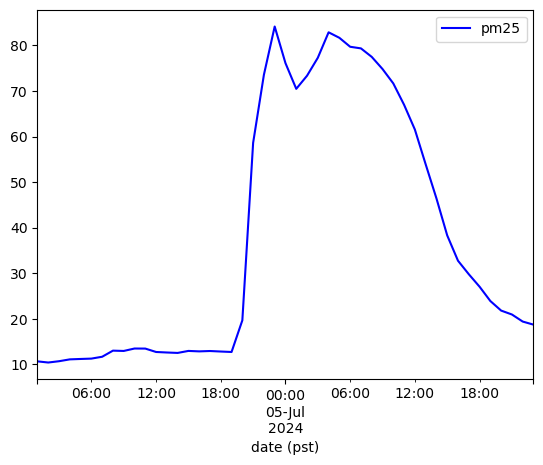

In [35]:
plot_fwd('Independence Day 2024', 2, df=nowcast_df)

In [36]:
combined_df = pd.DataFrame({
    'date (pst)' : processed_df['date (pst)'],
    'processed' : processed_df['pm25'],
    'processed, no dead impute': processed_df['pm25'],
    'raw_con' : rawcon_df['pm25'],
    'nowcast' : nowcast_df['pm25'],
    'left shifted nowcast' : nowcast_df['pm25'].shift(-1)
})
combined_df

,date (pst),processed,"processed, no dead impute",raw_con,nowcast,left shifted nowcast
0,2023-08-01 17:00:00-07:00,11.726666,11.726666,11.560000,11.726667,11.820000
1,2023-08-01 18:00:00-07:00,11.820001,11.820001,11.980000,11.820000,11.860000
2,2023-08-01 19:00:00-07:00,11.860001,11.860001,11.920000,11.860000,11.380000
3,2023-08-01 20:00:00-07:00,11.380001,11.380001,10.960000,11.380000,11.906667
4,2023-08-01 21:00:00-07:00,11.906668,11.906668,12.400000,11.906667,11.613333
...,...,...,...,...,...,...
17539,2025-08-01 12:00:00-07:00,13.017777,13.017777,12.635714,13.078571,12.692857
17540,2025-08-01 13:00:00-07:00,12.708889,12.708889,12.321429,12.692857,11.792857
17541,2025-08-01 14:00:00-07:00,11.771110,11.771110,10.957143,11.792857,11.350000
17542,2025-08-01 15:00:00-07:00,11.300000,11.300000,10.878571,11.350000,10.464286


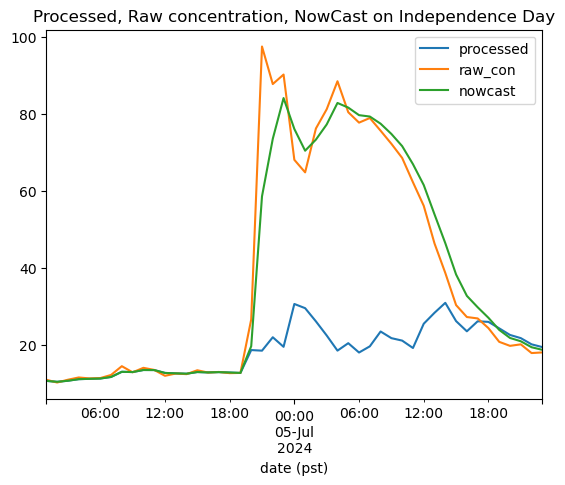

In [37]:
event, days_fwd = 'Independence Day 2024', 2
lo = dates_of_interest[event]
hi = dates_of_interest[event] + pd.Timedelta(days=days_fwd)
date_range = (combined_df['date (pst)'] > lo) & (combined_df['date (pst)'] < hi)

combined_df[date_range].plot(x='date (pst)', y=['processed', 'raw_con', 'nowcast'])
plt.title('Processed, Raw concentration, NowCast on Independence Day')
plt.show()

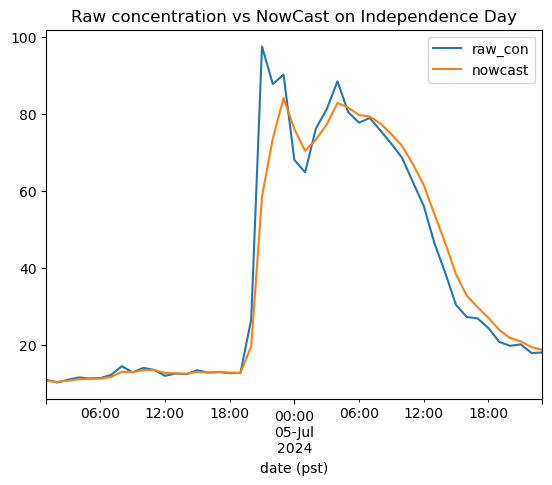

In [38]:
combined_df[date_range].plot(x='date (pst)', y=['raw_con', 'nowcast'])
plt.title('Raw concentration vs NowCast on Independence Day')
plt.show()

## Autocorrelation
$\rho(k) = \frac{\sum_{t=k+1}^{T} (x_t - \bar{x})(x_{t-k} - \bar{x})}{\sum_{t=1}^{T} (x_t - \bar{x})^2}$

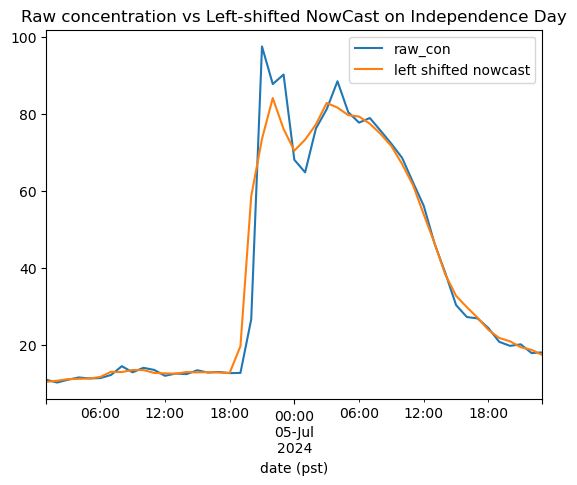

In [39]:
combined_df[date_range].plot(x='date (pst)', y=['raw_con', 'left shifted nowcast'])
plt.title('Raw concentration vs Left-shifted NowCast on Independence Day')
plt.show()

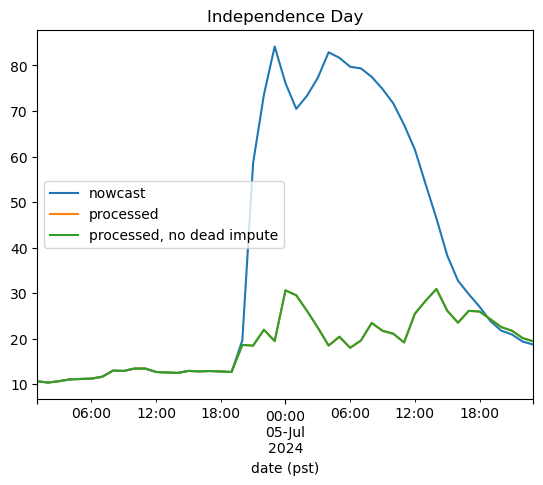

In [40]:
combined_df[date_range].plot(x='date (pst)', y=['nowcast', 'processed', 'processed, no dead impute'])
plt.title('Independence Day')
plt.show()

Theory: NowCast is responsive to quick upticks in PM2.5, but lags behind when PM2.5 is decreasing.

How does NowCast compare to Raw Concentration during normal scenarios?

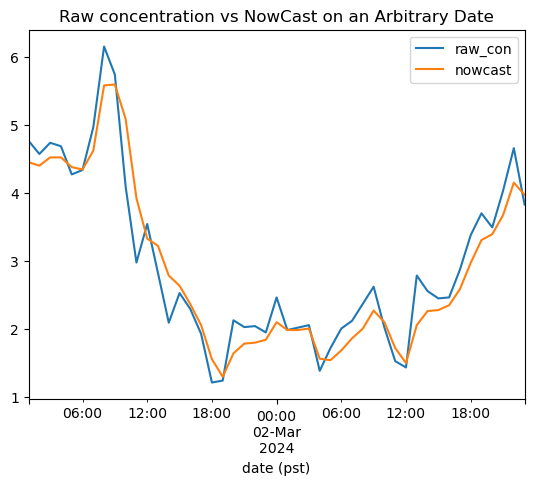

In [41]:
days_fwd = 2
lo = pd.to_datetime("2024-03-01").tz_localize('America/Los_Angeles')
hi = pd.to_datetime("2024-03-01").tz_localize('America/Los_Angeles') + pd.Timedelta(days=days_fwd)
date_range = (combined_df['date (pst)'] > lo) & (combined_df['date (pst)'] < hi)

combined_df[date_range].plot(x='date (pst)', y=['raw_con', 'nowcast'])
plt.title('Raw concentration vs NowCast on an Arbitrary Date')
plt.show()

<Axes: xlabel='date (pst)'>

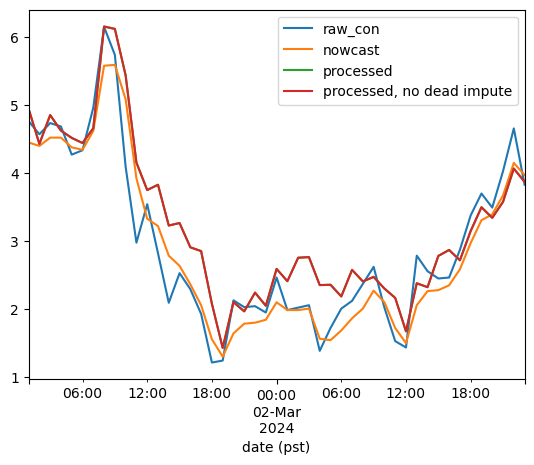

In [42]:
combined_df[date_range].plot(x='date (pst)', y=['raw_con', 'nowcast', 'processed','processed, no dead impute'])

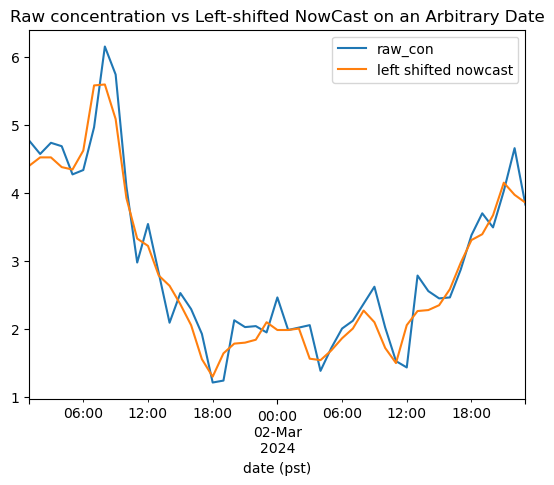

In [43]:
combined_df[date_range].plot(x='date (pst)', y=['raw_con', 'left shifted nowcast'])
plt.title('Raw concentration vs Left-shifted NowCast on an Arbitrary Date')
plt.show()

In [44]:
autocorr_df = pd.DataFrame({
    'processed' : [processed_df['pm25'].autocorr(lag=1)],
    'processed, no dead impute' : [processed_2_df['pm25'].autocorr(lag=1)],
    'raw_con' : [rawcon_df['pm25'].autocorr(lag=1)],
    'nowcast' : [nowcast_df['pm25'].autocorr(lag=1)]
})
autocorr_df

,processed,"processed, no dead impute",raw_con,nowcast
0,0.976783,0.97618,0.9595,0.982999


## Distribution Analysis

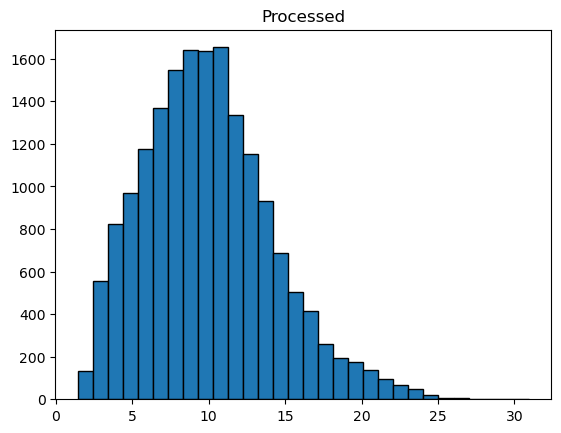

In [45]:
plt.title('Processed')
plt.hist(processed_df['pm25'], bins=30, edgecolor='black')
plt.show()

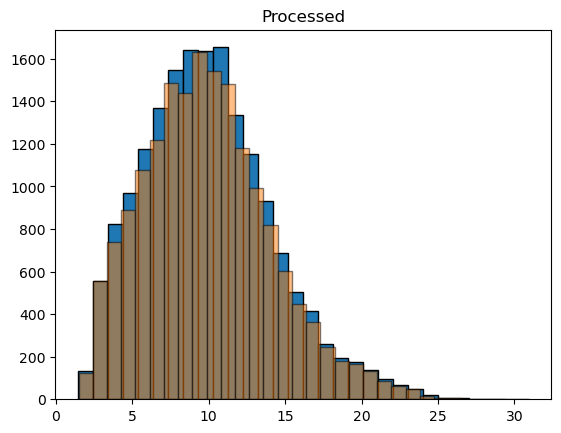

In [46]:
plt.title('Processed')
plt.hist(processed_df['pm25'], bins=30, edgecolor='black', alpha=1)
plt.hist(processed_2_df['pm25'], bins=30, edgecolor='black', alpha=0.5)
plt.show()

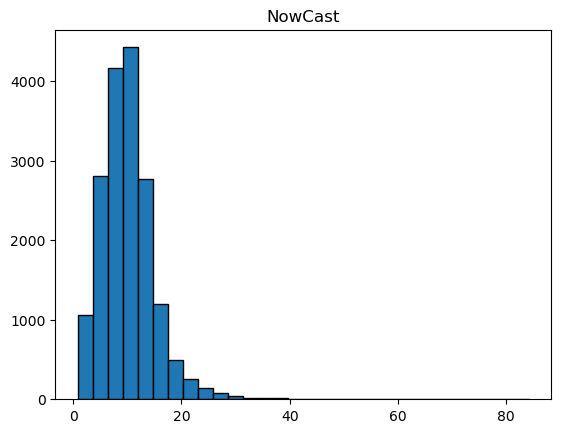

In [47]:
plt.title('NowCast')
plt.hist(nowcast_df['pm25'], bins=30, edgecolor='black')
plt.show()

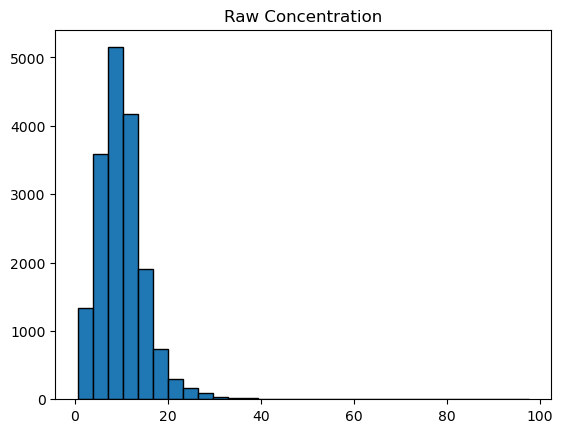

In [48]:
plt.title('Raw Concentration')
plt.hist(rawcon_df['pm25'], bins=30, edgecolor='black')
plt.show()

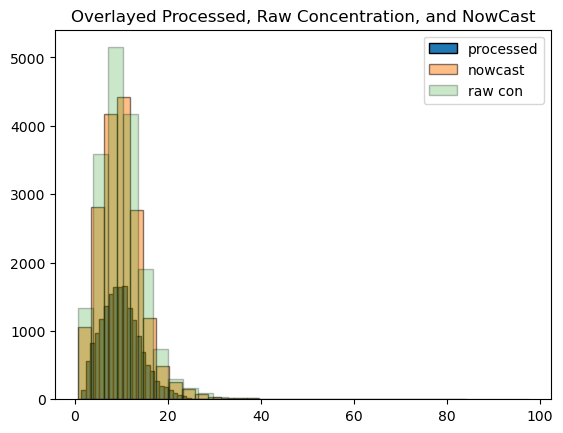

In [49]:
plt.title('Overlayed Processed, Raw Concentration, and NowCast')
plt.hist(processed_df['pm25'], bins=30, edgecolor='black', alpha=1, label='processed')
plt.hist(nowcast_df['pm25'], bins=30, edgecolor='black', alpha=0.5, label='nowcast')
plt.hist(rawcon_df['pm25'], bins=30, edgecolor='black', alpha=0.25, label='raw con')
plt.legend(loc='upper right')
plt.show()

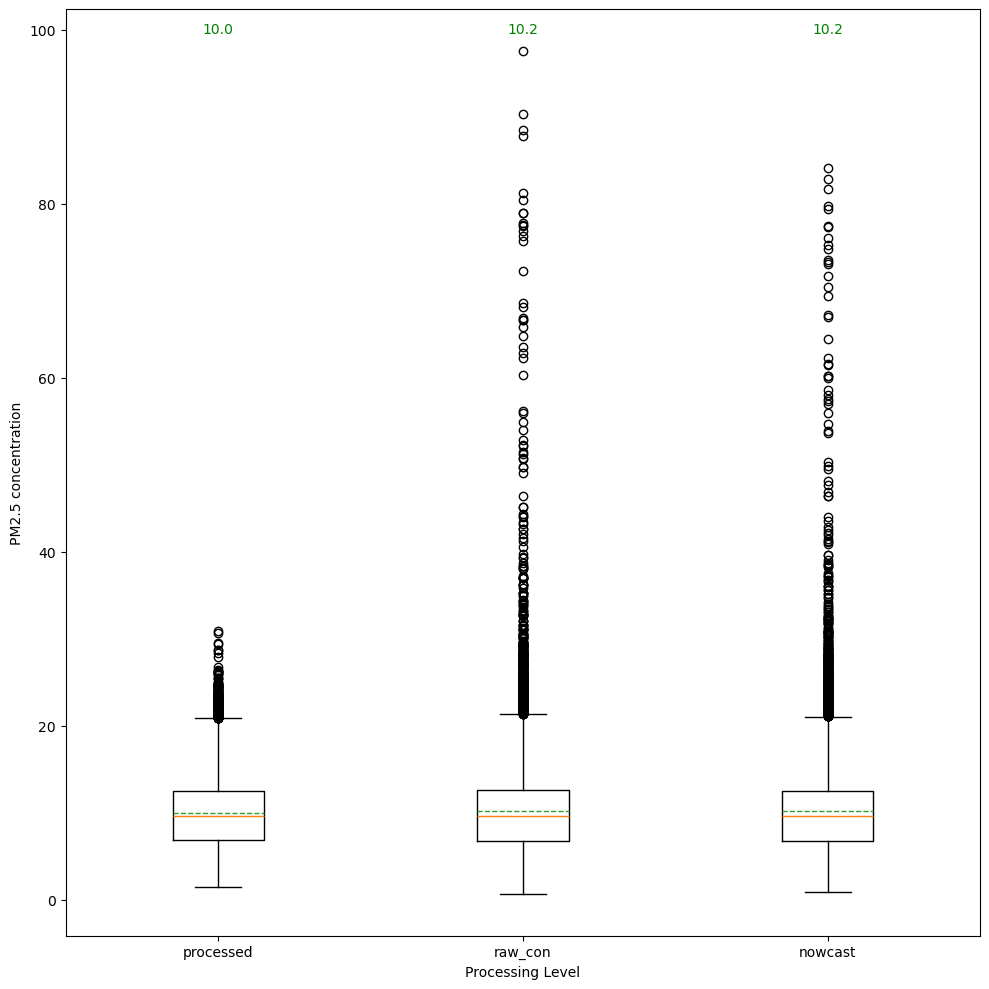

In [50]:
fig = plt.figure(figsize =(10, 10))

bp = plt.boxplot(
    [mean_processed, mean_raw_con, mean_nowcast], 
    tick_labels=stats_data.keys(), 
    meanline=True, 
    showmeans=True
)

# collect means and put them on the top row
upper_bound_text = np.max([mean_processed, mean_raw_con, mean_nowcast]) + 1.75
for i, mean in enumerate([mean.get_ydata()[0] for mean in bp['means']]):
    plt.text(i+1, upper_bound_text, f"{mean:.1f}", ha='center', va='bottom', color='green')
plt.ylabel("PM2.5 concentration")
plt.xlabel("Processing Level")
plt.tight_layout()
plt.show()